In [ ]:
import zipfile
import os

# 1. Dosya Yollarını Tanımla
zip_path = '/content/drive/MyDrive/Ara Proje/datalar/ara_proje_data.zip'
target_path = '/content/data'

# 2. Zipten Çıkar
if not os.path.exists(target_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(target_path)
    print("✅ Veri seti başarıyla çıkarıldı.")
else:
    print("📁 Veri zaten çıkarılmış, işleme devam ediliyor.")

# 3. Klasör Yapısını ve Sayıları Kontrol Et
def count_files(path):
    for root, dirs, files in os.walk(path):
        if not dirs: # Sadece en alt klasörlerdeki (sınıf klasörleri) dosyaları say
            count = len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            print(f"📊 {os.path.basename(root)}: {count} resim bulundu.")

print("\n--- BUSI Veri Seti Kontrolü ---")
count_files(target_path)

✅ Veri seti başarıyla çıkarıldı.

--- BUSI Veri Seti Kontrolü ---
📊 malignant: 32 resim bulundu.
📊 normal: 21 resim bulundu.
📊 benign: 67 resim bulundu.
📊 malignant: 31 resim bulundu.
📊 normal: 19 resim bulundu.
📊 benign: 65 resim bulundu.
📊 malignant: 2379 resim bulundu.
📊 normal: 2181 resim bulundu.
📊 benign: 2471 resim bulundu.


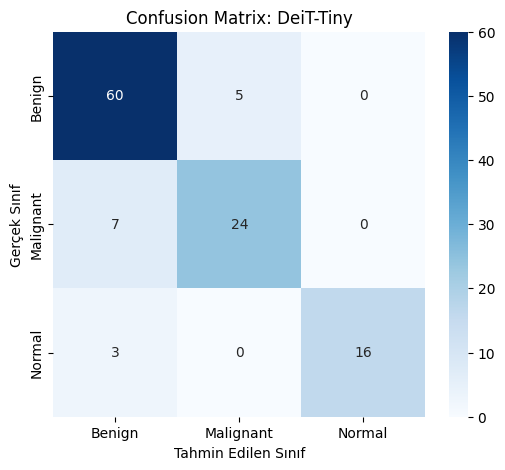

In [ ]:
import torch, timm, os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Ayarlar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = '/content/drive/MyDrive/Ara Proje/saved_models/TF models/deit_busi_final_v3.pth'
test_dir = '/content/data/test'
class_names = ['Benign', 'Malignant', 'Normal']

# Transform
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_loader = DataLoader(datasets.ImageFolder(test_dir, transform=transform), batch_size=32, shuffle=False)

# Model Yükleme
model = timm.create_model('deit_tiny_patch16_224', pretrained=False, num_classes=3).to(device)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint)
model.eval()

# Tahmin
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.numpy())

# Matris Çizimi
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix: DeiT-Tiny')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

🔄 BEiT Transformer (v6) yükleniyor...


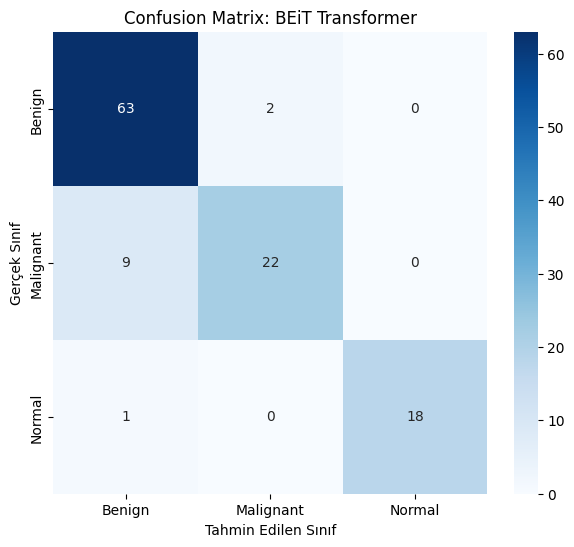

In [ ]:
import torch
import timm
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. Ayarlar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = '/content/drive/MyDrive/Ara Proje/saved_models/TF models/beit_busi_final_v6.pth'
test_dir = '/content/data/test'
class_names = ['Benign', 'Malignant', 'Normal']

# 2. Veri Yükleyici (BEiT için 0.5 mean/std)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 3. Model Kurulumu ve Ağırlık Yükleme
print(f"🔄 BEiT Transformer (v6) yükleniyor...")

# Hata alınan yer düzeltildi: Eğitimde kullanılan 'beit_base' ismi deneniyor
model_name = 'beit_base_patch16_224.in22k_ft_in22k'

try:
    model = timm.create_model(model_name, pretrained=False, num_classes=3)
except RuntimeError:
    # Eğer yukarıdaki isim de hata verirse en jenerik ismi dene
    model_name = 'beit_base_patch16_224'
    model = timm.create_model(model_name, pretrained=False, num_classes=3)

checkpoint = torch.load(model_path)
state_dict = checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint
model.load_state_dict(state_dict)
model.to(device)
model.eval()

# 4. Tahminlerin Toplanması
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 5. Confusion Matrix Görselleştirme (Sade ve Standart Format)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix: BEiT Transformer')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

In [ ]:
import torch
import timm
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. Ayarlar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = '/content/drive/MyDrive/Ara Proje/saved_models/TF models/vit_busi_v3.pth'
test_dir = '/content/data/test'
class_names = ['Benign', 'Malignant', 'Normal']

# 2. Veri Yükleyici (ViT için 224x224 standart)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 3. Model Kurulumu ve Ağırlık Yükleme
print(f"🔄 ViT (Standard) yükleniyor...")
model = timm.create_model('vit_tiny_patch16_224', pretrained=False, num_classes=3)
checkpoint = torch.load(model_path)

state_dict = checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint
model.load_state_dict(state_dict)
model.to(device)
model.eval()

# 4. Tahminlerin Toplanması
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 5. Confusion Matrix Görselleştirme
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix: ViT')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

🔄 ViT (Standard) yükleniyor...


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Ara Proje/saved_models/TF models/vit_busi_v3.pth'

🔄 Swin Transformer (v4) yükleniyor...


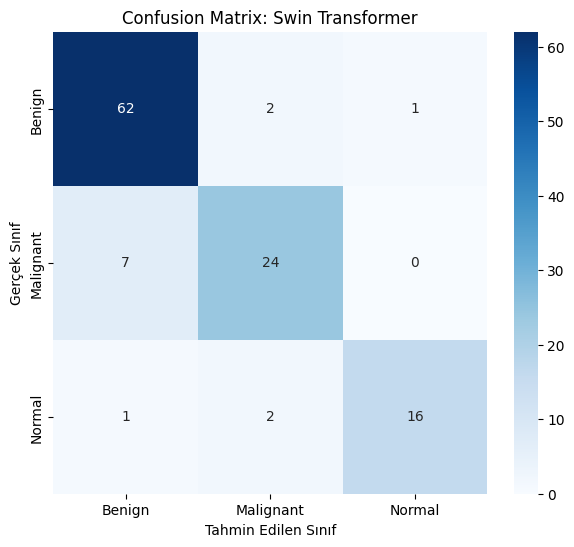

In [ ]:
import torch, timm, os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Ayarlar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = '/content/drive/MyDrive/Ara Proje/saved_models/TF models/swin_busi_final_v4.pth'
test_dir = '/content/data/test'
class_names = ['Benign', 'Malignant', 'Normal']

# Veri Hazırlığı
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
test_loader = DataLoader(datasets.ImageFolder(test_dir, transform=transform), batch_size=32, shuffle=False)

# Model Yükleme
print("🔄 Swin Transformer (v4) yükleniyor...")
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=3).to(device)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint)
model.eval()

# Tahmin
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.numpy())

# Çizim
plt.figure(figsize=(7, 6))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix: Swin Transformer')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

🔄 CaiT Transformer (v5) yükleniyor...


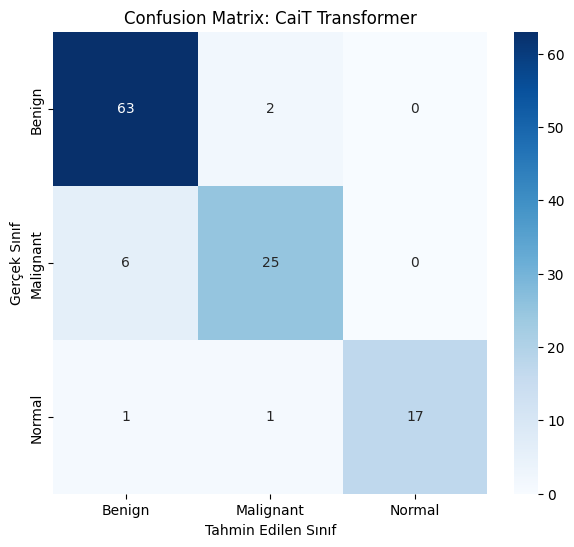

In [ ]:
import torch, timm, os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Ayarlar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = '/content/drive/MyDrive/Ara Proje/saved_models/TF models/cait_busi_final_v5.pth'
test_dir = '/content/data/test'
class_names = ['Benign', 'Malignant', 'Normal']

# Veri Hazırlığı
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
test_loader = DataLoader(datasets.ImageFolder(test_dir, transform=transform), batch_size=32, shuffle=False)

# Model Yükleme
print("🔄 CaiT Transformer (v5) yükleniyor...")
model = timm.create_model('cait_s24_224', pretrained=False, num_classes=3).to(device)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint)
model.eval()

# Tahmin
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.numpy())

# Çizim
plt.figure(figsize=(7, 6))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix: CaiT Transformer')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

DeiT-Tiny (Data-efficient Image Transformer)

In [ ]:
# 1. Kütüphaneler
!pip install timm
import torch
import torch.nn as nn
import timm
import os
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive

# 2. Drive ve Kayıt Yolu
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/Ara Proje/saved_models/TF models/deit_busi_final_v3.pth'

# 3. Klasör Yollarını Tanımla
train_dir = '/content/data/train'
valid_dir = '/content/data/valid'
test_dir = '/content/data/test'

# 4. Veri Dönüşümleri (Transformations)
# Train için augmentation (artırma), Valid/Test için sadece normalize
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 5. Dataset ve DataLoader Oluşturma
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=val_test_transform)
test_data = datasets.ImageFolder(test_dir, transform=val_test_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"✅ Veri Setleri Hazır:")
print(f"Eğitim (Train): {len(train_data)} | Doğrulama (Valid): {len(valid_data)} | Test: {len(test_data)}")

# 6. DeiT Model Kurulumu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('deit_tiny_patch16_224', pretrained=True, num_classes=3)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
criterion = nn.CrossEntropyLoss()

# 7. Eğitim Döngüsü ve Early Stopping
epochs = 50
best_acc = 0.0
patience = 5
counter = 0

print(f"\n🚀 Disiplinli Eğitim Başlıyor... (Cihaz: {device})")

for epoch in range(epochs):
    # --- TRAIN ---
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    # --- VALIDATION ---
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100. * val_correct / val_total

    print(f'Epoch [{epoch+1}/{epochs}] - Loss: {train_loss/len(train_loader):.4f} - Train Acc: %{100.*train_correct/train_total:.2f} - Val Acc: %{val_acc:.2f}')

    # Save Best Model based on Validation Accuracy
    if val_acc > best_acc:
        best_acc = val_acc
        counter = 0
        torch.save({'model_state_dict': model.state_dict(), 'best_acc': best_acc}, save_path)
        print(f'⭐ En İyi Model Kaydedildi (Val Acc: %{best_acc:.2f})')
    else:
        counter += 1
        if counter >= patience:
            print(f'🛑 Early Stopping tetiklendi. En iyi Val Acc: %{best_acc:.2f}')
            break

print("\n✅ Eğitim bitti. Şimdi Test klasörüyle final performansını ölçebiliriz.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Veri Setleri Hazır:
Eğitim (Train): 7031 | Doğrulama (Valid): 120 | Test: 115

🚀 Disiplinli Eğitim Başlıyor... (Cihaz: cuda)
Epoch [1/50] - Loss: 0.3527 - Train Acc: %86.39 - Val Acc: %80.00
⭐ En İyi Model Kaydedildi (Val Acc: %80.00)
Epoch [2/50] - Loss: 0.1357 - Train Acc: %95.28 - Val Acc: %88.33
⭐ En İyi Model Kaydedildi (Val Acc: %88.33)
Epoch [3/50] - Loss: 0.0838 - Train Acc: %97.16 - Val Acc: %86.67
Epoch [4/50] - Loss: 0.0677 - Train Acc: %97.60 - Val Acc: %85.83
Epoch [5/50] - Loss: 0.0497 - Train Acc: %98.22 - Val Acc: %81.67
Epoch [6/50] - Loss: 0.0410 - Train Acc: %98.56 - Val Acc: %85.00
Epoch [7/50] - Loss: 0.0410 - Train Acc: %98.56 - Val Acc: %85.00
🛑 Early Stopping tetiklendi. En iyi Val Acc: %88.33

✅ Eğitim bitti. Şimdi Test klasörüyle final performansını ölçebiliriz.


🔍 Tamamen Bağımsız TEST Klasörü Analiz Ediliyor...

🚀 DeiT TRANSFORMER - FİNAL TEST SONUÇLARI
Test Accuracy (Doğruluk)  : %86.96
Test Recall (Duyarlılık)   : %84.65
Test Precision (Kesinlik) : %89.49
Test F1-Score             : %86.77
--------------------------------------------------

Sınıf Bazlı Detaylı Analiz:
              precision    recall  f1-score   support

      benign       0.86      0.92      0.89        65
   malignant       0.83      0.77      0.80        31
      normal       1.00      0.84      0.91        19

    accuracy                           0.87       115
   macro avg       0.89      0.85      0.87       115
weighted avg       0.87      0.87      0.87       115



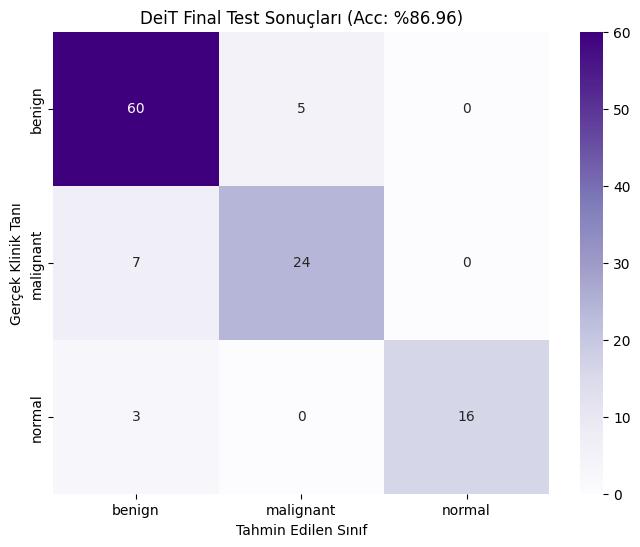

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import timm

# 1. Kayıtlı En İyi Modeli Yükle (v3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('deit_tiny_patch16_224', pretrained=False, num_classes=3)
checkpoint = torch.load('/content/drive/MyDrive/Ara Proje/saved_models/TF models/deit_busi_final_v3.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

all_preds = []
all_labels = []

print("🔍 Tamamen Bağımsız TEST Klasörü Analiz Ediliyor...")

# 2. Test Döngüsü
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 3. Metrikleri Hesapla
class_names = test_data.classes # ['benign', 'malignant', 'normal']
acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

print("\n" + "="*50)
print(f"🚀 DeiT TRANSFORMER - FİNAL TEST SONUÇLARI")
print("="*50)
print(f"Test Accuracy (Doğruluk)  : %{acc*100:.2f}")
print(f"Test Recall (Duyarlılık)   : %{recall*100:.2f}")
print(f"Test Precision (Kesinlik) : %{precision*100:.2f}")
print(f"Test F1-Score             : %{f1*100:.2f}")
print("-" * 50)
print("\nSınıf Bazlı Detaylı Analiz:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# 4. Karışıklık Matrisi (Confusion Matrix)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Klinik Tanı')
plt.title(f'DeiT Final Test Sonuçları (Acc: %{acc*100:.2f})')
plt.show()

In [ ]:
import os
import torch
from PIL import Image
import timm
from torchvision import transforms

# 1. Klasör Yolu (Önceki adımda çıkardığımız yer)
deneme_path = '/content/deneme_test/denem'

# 2. Modeli Yükle (Final Disiplinli Eğitimden çıkan v3 modeli)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('deit_tiny_patch16_224', pretrained=False, num_classes=3)
checkpoint = torch.load('/content/drive/MyDrive/Ara Proje/saved_models/TF models/deit_busi_final_v3.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# 3. Test Ön İşleme
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class_names = ['benign', 'malignant', 'normal']

# 4. Tahmin Döngüsü
print(f"🔍 Dışarıdan Gelen 'denem' Klasörü Test Ediliyor...\n")
print(f"{'Dosya Adı':<35} | {'Tahmin Edilen Sınıf'}")
print("-" * 60)

found_files = 0
with torch.no_grad():
    # Klasördeki tüm resimleri listele ve alfabetik sırala
    files = sorted(os.listdir(deneme_path))
    for img_name in files:
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            found_files += 1
            img_path = os.path.join(deneme_path, img_name)

            image = Image.open(img_path).convert('RGB')
            img_tensor = test_transform(image).unsqueeze(0).to(device)

            outputs = model(img_tensor)
            _, predicted = outputs.max(1)
            pred_class = class_names[predicted.item()]

            print(f"{img_name:<35} | {pred_class.upper()}")

if found_files == 0:
    print("❌ HATA: Resimler bulunamadı. Lütfen yolu kontrol et: ", deneme_path)
else:
    print(f"\n✅ Toplam {found_files} dış örnek başarıyla test edildi.")

🔍 Dışarıdan Gelen 'denem' Klasörü Test Ediliyor...

Dosya Adı                           | Tahmin Edilen Sınıf
------------------------------------------------------------
benign (100)-rotated1-rotated2.png  | BENIGN
benign (101)-rotated1.jpg           | BENIGN
benign (101)-sharpened.jpg          | BENIGN
benign (102)-rotated2-rotated1.png  | BENIGN
benign (103)-rotated2-rotated1.png  | BENIGN
benign (105)-rotated2-rotated2.png  | BENIGN
benign (105)-rotated2.png           | BENIGN
benign (107)-rotated2-sharpened.png | BENIGN
benign (108)-rotated2-rotated2.png  | BENIGN
benign (110)-sharpened-sharpened.png | BENIGN
benign (111)-rotated1-sharpened.png | BENIGN
malignant (105)-rotated32.png       | MALIGNANT
malignant (106)-sharpened-rotated32.png | MALIGNANT
malignant (107)-rotated1-rotated32.png | MALIGNANT
malignant (108)-rotated1-rotated32.png | MALIGNANT
malignant (109)-rotated1-rotated32.png | MALIGNANT
malignant (110)-rotated32-rotated2.png | MALIGNANT
malignant (111)-rotated2-shar

Swin Transformer


In [ ]:
# 1. Kütüphaneler
!pip install timm
import torch
import torch.nn as nn
import timm
import os
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive

# 2. Drive ve Kayıt Yolu (Swin için v4 olarak kaydediyoruz)
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/Ara Proje/saved_models/TF models/swin_busi_final_v4.pth'

# 3. Klasör Yolları
train_dir = '/content/data/train'
valid_dir = '/content/data/valid'
test_dir = '/content/data/test'

# 4. Veri Dönüşümleri (Transformations)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 5. Dataset ve DataLoader
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=val_test_transform)
test_data = datasets.ImageFolder(test_dir, transform=val_test_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"✅ Veri Setleri Hazır (Swin için)")
print(f"Eğitim: {len(train_data)} | Doğrulama: {len(valid_data)} | Test: {len(test_data)}")

# 6. Swin Transformer Model Kurulumu
# 'swin_tiny_patch4_window7_224' modelini kullanıyoruz
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=3)
model.to(device)



optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
criterion = nn.CrossEntropyLoss()

# 7. Eğitim Döngüsü ve Early Stopping
epochs = 50
best_acc = 0.0
patience = 5
counter = 0

print(f"\n🚀 Swin Transformer Eğitimi Başlıyor... (Cihaz: {device})")

for epoch in range(epochs):
    # --- TRAIN ---
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    # --- VALIDATION ---
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100. * val_correct / val_total

    print(f'Epoch [{epoch+1}/{epochs}] - Loss: {train_loss/len(train_loader):.4f} - Train Acc: %{100.*train_correct/train_total:.2f} - Val Acc: %{val_acc:.2f}')

    # Save Best Model
    if val_acc > best_acc:
        best_acc = val_acc
        counter = 0
        torch.save({'model_state_dict': model.state_dict(), 'best_acc': best_acc}, save_path)
        print(f'⭐ Yeni En İyi Swin Modeli Kaydedildi (Val Acc: %{best_acc:.2f})')
    else:
        counter += 1
        if counter >= patience:
            print(f'🛑 Early Stopping tetiklendi. En iyi Swin Val Acc: %{best_acc:.2f}')
            break

print("\n✅ Swin eğitimi bitti. Sonuçlar gelince test aşamasına geçelim.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Veri Setleri Hazır (Swin için)
Eğitim: 7031 | Doğrulama: 120 | Test: 115


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]


🚀 Swin Transformer Eğitimi Başlıyor... (Cihaz: cuda)
Epoch [1/50] - Loss: 0.3184 - Train Acc: %87.65 - Val Acc: %87.50
⭐ Yeni En İyi Swin Modeli Kaydedildi (Val Acc: %87.50)
Epoch [2/50] - Loss: 0.0882 - Train Acc: %96.76 - Val Acc: %87.50
Epoch [3/50] - Loss: 0.0704 - Train Acc: %97.64 - Val Acc: %87.50
Epoch [4/50] - Loss: 0.0455 - Train Acc: %98.26 - Val Acc: %90.00
⭐ Yeni En İyi Swin Modeli Kaydedildi (Val Acc: %90.00)
Epoch [5/50] - Loss: 0.0459 - Train Acc: %98.46 - Val Acc: %90.83
⭐ Yeni En İyi Swin Modeli Kaydedildi (Val Acc: %90.83)
Epoch [6/50] - Loss: 0.0465 - Train Acc: %98.29 - Val Acc: %89.17
Epoch [7/50] - Loss: 0.0295 - Train Acc: %98.89 - Val Acc: %89.17


KeyboardInterrupt: 

🔍 Swin Transformer: Test Klasörü Analiz Ediliyor...

🚀 SWIN TRANSFORMER - TEST SONUÇLARI
              precision    recall  f1-score   support

      benign       0.89      0.95      0.92        65
   malignant       0.86      0.77      0.81        31
      normal       0.94      0.84      0.89        19

    accuracy                           0.89       115
   macro avg       0.89      0.86      0.87       115
weighted avg       0.89      0.89      0.89       115



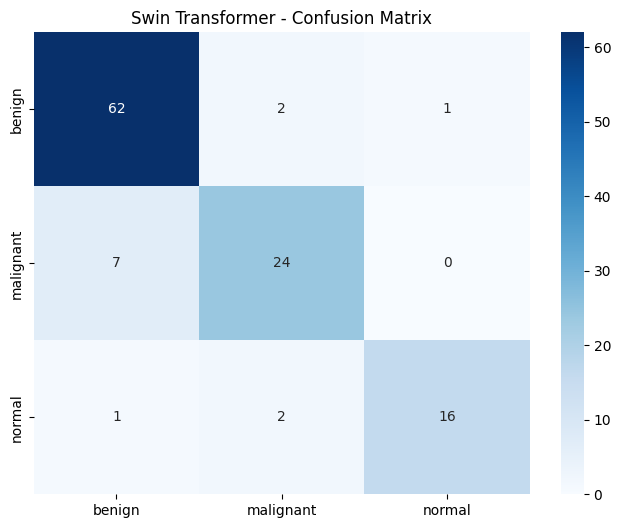


🔍 Dışarıdan Gelen 'denem' Klasörü Tahminleri Başlıyor...

Dosya Adı                           | Tahmin Edilen
-------------------------------------------------------
benign (100)-rotated1-rotated2.png  | BENIGN
benign (101)-rotated1.jpg           | BENIGN
benign (101)-sharpened.jpg          | BENIGN
benign (102)-rotated2-rotated1.png  | BENIGN
benign (103)-rotated2-rotated1.png  | BENIGN
benign (105)-rotated2-rotated2.png  | BENIGN
benign (105)-rotated2.png           | BENIGN
benign (107)-rotated2-sharpened.png | BENIGN
benign (108)-rotated2-rotated2.png  | BENIGN
benign (110)-sharpened-sharpened.png | BENIGN
benign (111)-rotated1-sharpened.png | BENIGN
malignant (105)-rotated32.png       | MALIGNANT
malignant (106)-sharpened-rotated32.png | MALIGNANT
malignant (107)-rotated1-rotated32.png | MALIGNANT
malignant (108)-rotated1-rotated32.png | MALIGNANT
malignant (109)-rotated1-rotated32.png | MALIGNANT
malignant (110)-rotated32-rotated2.png | MALIGNANT
malignant (111)-rotated2-sharpene

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import timm
import os

# 1. Modeli Yükle (Swin v4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=3)
checkpoint = torch.load('/content/drive/MyDrive/Ara Proje/saved_models/TF models/swin_busi_final_v4.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# 2. Test Klasörü Analizi (Final Metrikler)
test_dir = '/content/data/test'
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_data = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

all_preds, all_labels = [], []

print("🔍 Swin Transformer: Test Klasörü Analiz Ediliyor...")
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Raporu Yazdır
class_names = test_data.classes
print("\n" + "="*50)
print(f"🚀 SWIN TRANSFORMER - TEST SONUÇLARI")
print("="*50)
print(classification_report(all_labels, all_preds, target_names=class_names))

# Karışıklık Matrisi
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Swin Transformer - Confusion Matrix')
plt.show()

# 3. Bağımsız 'denem' Klasörü Tahminleri
deneme_path = '/content/deneme_test/denem'
if os.path.exists(deneme_path):
    print(f"\n🔍 Dışarıdan Gelen 'denem' Klasörü Tahminleri Başlıyor...\n")
    print(f"{'Dosya Adı':<35} | {'Tahmin Edilen'}")
    print("-" * 55)

    with torch.no_grad():
        files = sorted(os.listdir(deneme_path))
        for img_name in files:
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(deneme_path, img_name)
                image = Image.open(img_path).convert('RGB')
                img_tensor = test_transform(image).unsqueeze(0).to(device)

                outputs = model(img_tensor)
                _, predicted = outputs.max(1)
                print(f"{img_name:<35} | {class_names[predicted.item()].upper()}")
else:
    print(f"\n⚠️ Uyarı: {deneme_path} yolu bulunamadı.")

In [ ]:
import os
import torch
from PIL import Image
import timm
from torchvision import transforms

# 1. Klasör Yolu
deneme_path = '/content/deneme_test/denem'

# 2. Swin Transformer Modelini Yükle (v4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=3)
checkpoint = torch.load('/content/drive/MyDrive/Ara Proje/saved_models/TF models/swin_busi_final_v4.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# 3. Test Ön İşleme (Normalization değerleri ImageNet standartlarında)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class_names = ['benign', 'malignant', 'normal']

# 4. Tahmin Döngüsü
print(f"🔍 Swin Transformer - 'denem' Klasörü Kör Testi (Blind Test)...\n")
print(f"{'Dosya Adı':<35} | {'Tahmin Edilen Sınıf'}")
print("-" * 60)

found_files = 0
with torch.no_grad():
    # Klasördeki tüm resimleri listele ve sırala
    files = sorted(os.listdir(deneme_path))
    for img_name in files:
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            found_files += 1
            img_path = os.path.join(deneme_path, img_name)

            # Resmi aç ve RGB'ye çevir
            image = Image.open(img_path).convert('RGB')
            img_tensor = test_transform(image).unsqueeze(0).to(device)

            # Tahmin
            outputs = model(img_tensor)
            _, predicted = outputs.max(1)
            pred_class = class_names[predicted.item()]

            print(f"{img_name:<35} | {pred_class.upper()}")

if found_files == 0:
    print(f"❌ HATA: '{deneme_path}' içinde resim bulunamadı.")
else:
    print(f"\n✅ Toplam {found_files} dış örnek Swin Transformer ile test edildi.")

🔍 Swin Transformer - 'denem' Klasörü Kör Testi (Blind Test)...

Dosya Adı                           | Tahmin Edilen Sınıf
------------------------------------------------------------
benign (100)-rotated1-rotated2.png  | BENIGN
benign (101)-rotated1.jpg           | BENIGN
benign (101)-sharpened.jpg          | BENIGN
benign (102)-rotated2-rotated1.png  | BENIGN
benign (103)-rotated2-rotated1.png  | BENIGN
benign (105)-rotated2-rotated2.png  | BENIGN
benign (105)-rotated2.png           | BENIGN
benign (107)-rotated2-sharpened.png | BENIGN
benign (108)-rotated2-rotated2.png  | BENIGN
benign (110)-sharpened-sharpened.png | BENIGN
benign (111)-rotated1-sharpened.png | BENIGN
malignant (105)-rotated32.png       | MALIGNANT
malignant (106)-sharpened-rotated32.png | MALIGNANT
malignant (107)-rotated1-rotated32.png | MALIGNANT
malignant (108)-rotated1-rotated32.png | MALIGNANT
malignant (109)-rotated1-rotated32.png | MALIGNANT
malignant (110)-rotated32-rotated2.png | MALIGNANT
malignant (111)-r

In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import timm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. Modeli Yükle (Swin v4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=3)
checkpoint = torch.load('/content/drive/MyDrive/Ara Proje/saved_models/TF models/swin_busi_final_v4.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# 2. Test Verisi Hazırlığı
test_dir = '/content/data/test'
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_data = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# 3. Tahminleri Topla
all_preds = []
all_labels = []

print("🔍 4 Temel Metrik Hesaplanıyor...")
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 4. Metriklerin Hesaplanması
acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

# 5. Sonuçları Yazdır
print("\n" + "="*40)
print(f"📊 SWIN TRANSFORMER GENEL PERFORMANS")
print("="*40)
print(f"{'Metrik':<20} | {'Skor':<10}")
print("-" * 35)
print(f"{'Accuracy':<20} | %{acc*100:.2f}")
print(f"{'Precision (Macro)':<20} | %{precision*100:.2f}")
print(f"{'Recall (Macro)':<20} | %{recall*100:.2f}")
print(f"{'F1-Score (Macro)':<20} | %{f1*100:.2f}")
print("="*40)

🔍 4 Temel Metrik Hesaplanıyor...

📊 SWIN TRANSFORMER GENEL PERFORMANS
Metrik               | Skor      
-----------------------------------
Accuracy             | %88.70
Precision (Macro)    | %89.47
Recall (Macro)       | %85.67
F1-Score (Macro)     | %87.37


CaiT (Class-Attention in Image Transformers)

In [ ]:
# 1. Kütüphaneler
!pip install timm
import torch
import torch.nn as nn
import timm
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive

# 2. Drive ve Kayıt Yolu (v5 - CaiT Modeli)
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/Ara Proje/saved_models/TF models/cait_busi_final_v5.pth'

# 3. Klasör Yolları
train_dir = '/content/data/train'
valid_dir = '/content/data/valid'
test_dir = '/content/data/test'

# 4. Veri Dönüşümleri
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 5. Dataset ve DataLoader
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=val_test_transform)
test_data = datasets.ImageFolder(test_dir, transform=val_test_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# 6. CaiT Model Kurulumu (Meşhur ve Güçlü)
# 'cait_s24_224' modeli, derinliği ve performansıyla bilinir.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('cait_s24_224', pretrained=True, num_classes=3)
model.to(device)



optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.05) # CaiT için biraz daha düşük LR iyidir
criterion = nn.CrossEntropyLoss()

# 7. Eğitim Döngüsü (Early Stopping ile)
epochs = 50
best_acc = 0.0
patience = 5
counter = 0

print(f"\n🚀 CaiT Transformer Eğitimi Başlıyor... (Cihaz: {device})")

for epoch in range(epochs):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100. * val_correct / val_total
    print(f'Epoch [{epoch+1}/{epochs}] - Loss: {train_loss/len(train_loader):.4f} - Train Acc: %{100.*train_correct/train_total:.2f} - Val Acc: %{val_acc:.2f}')

    if val_acc > best_acc:
        best_acc = val_acc
        counter = 0
        torch.save({'model_state_dict': model.state_dict(), 'best_acc': best_acc}, save_path)
        print(f'⭐ En İyi CaiT Modeli Kaydedildi!')
    else:
        counter += 1
        if counter >= patience:
            print(f'🛑 Early Stopping: %{best_acc:.2f} val başarısında durduruldu.')
            break

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


model.safetensors:   0%|          | 0.00/188M [00:00<?, ?B/s]


🚀 CaiT Transformer Eğitimi Başlıyor... (Cihaz: cuda)
Epoch [1/50] - Loss: 0.2179 - Train Acc: %91.51 - Val Acc: %85.83
⭐ En İyi CaiT Modeli Kaydedildi!
Epoch [2/50] - Loss: 0.0414 - Train Acc: %98.66 - Val Acc: %89.17
⭐ En İyi CaiT Modeli Kaydedildi!
Epoch [3/50] - Loss: 0.0354 - Train Acc: %98.66 - Val Acc: %88.33
Epoch [4/50] - Loss: 0.0254 - Train Acc: %98.86 - Val Acc: %86.67
Epoch [5/50] - Loss: 0.0158 - Train Acc: %99.37 - Val Acc: %85.83
Epoch [6/50] - Loss: 0.0160 - Train Acc: %99.25 - Val Acc: %83.33
Epoch [7/50] - Loss: 0.0249 - Train Acc: %99.03 - Val Acc: %90.00
⭐ En İyi CaiT Modeli Kaydedildi!
Epoch [8/50] - Loss: 0.0313 - Train Acc: %98.73 - Val Acc: %91.67
⭐ En İyi CaiT Modeli Kaydedildi!
Epoch [9/50] - Loss: 0.0222 - Train Acc: %99.06 - Val Acc: %90.00


KeyboardInterrupt: 

In [ ]:
deneme_path = '/content/deneme_test/denem'

print(f"\n🔍 Dışarıdan Gelen 'denem' Klasörü Tahminleri (CaiT)...\n")
print(f"{'Dosya Adı':<35} | {'Tahmin Edilen'}")
print("-" * 55)

with torch.no_grad():
    if os.path.exists(deneme_path):
        files = sorted(os.listdir(deneme_path))
        for img_name in files:
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(deneme_path, img_name)
                image = Image.open(img_path).convert('RGB')
                img_tensor = test_transform(image).unsqueeze(0).to(device)

                outputs = model(img_tensor)
                _, predicted = outputs.max(1)
                print(f"{img_name:<35} | {class_names[predicted.item()].upper()}")
    else:
        print("⚠️ 'denem' klasörü bulunamadı!")


🔍 Dışarıdan Gelen 'denem' Klasörü Tahminleri (CaiT)...

Dosya Adı                           | Tahmin Edilen
-------------------------------------------------------
benign (100)-rotated1-rotated2.png  | BENIGN
benign (101)-rotated1.jpg           | BENIGN
benign (101)-sharpened.jpg          | BENIGN
benign (102)-rotated2-rotated1.png  | BENIGN
benign (103)-rotated2-rotated1.png  | BENIGN
benign (105)-rotated2-rotated2.png  | BENIGN
benign (105)-rotated2.png           | BENIGN
benign (107)-rotated2-sharpened.png | BENIGN
benign (108)-rotated2-rotated2.png  | BENIGN
benign (110)-sharpened-sharpened.png | BENIGN
benign (111)-rotated1-sharpened.png | BENIGN
malignant (105)-rotated32.png       | MALIGNANT
malignant (106)-sharpened-rotated32.png | MALIGNANT
malignant (107)-rotated1-rotated32.png | MALIGNANT
malignant (108)-rotated1-rotated32.png | MALIGNANT
malignant (109)-rotated1-rotated32.png | MALIGNANT
malignant (110)-rotated32-rotated2.png | MALIGNANT
malignant (111)-rotated2-sharpened.


🏆 CAIT TRANSFORMER MODELİ - FİNAL PERFORMANS RAPORU
METRİK                    | SKOR      
----------------------------------------
Genel Doğruluk (Acc)      | %91.30
Kesinlik (Precision)      | %93.10
Duyarlılık (Recall)       | %89.01
F1-Skoru                  | %90.84
------------------------------------------------------------

📝 SINIF BAZLI DETAYLI ANALİZ:
              precision    recall  f1-score   support

      benign       0.90      0.97      0.93        65
   malignant       0.89      0.81      0.85        31
      normal       1.00      0.89      0.94        19

    accuracy                           0.91       115
   macro avg       0.93      0.89      0.91       115
weighted avg       0.91      0.91      0.91       115



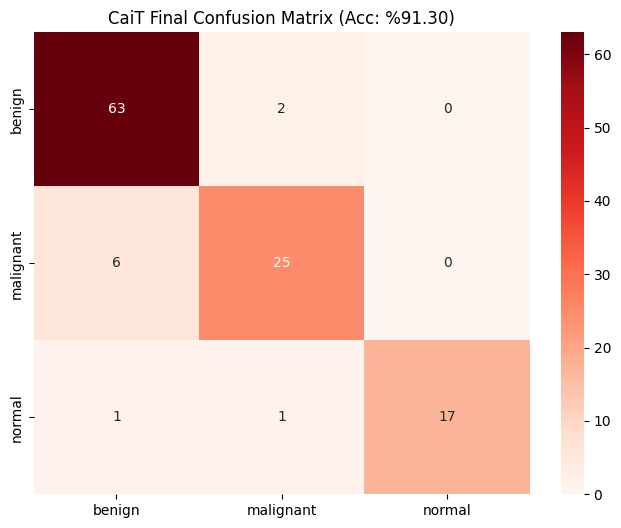


🔍 DIŞARDAN GELEN 'DENEM' KLASÖRÜ TAHMİNLERİ (27 RESİM)
Dosya Adı                           | Tahmin Edilen
-------------------------------------------------------
benign (100)-rotated1-rotated2.png  | BENIGN
benign (101)-rotated1.jpg           | BENIGN
benign (101)-sharpened.jpg          | BENIGN
benign (102)-rotated2-rotated1.png  | BENIGN
benign (103)-rotated2-rotated1.png  | BENIGN
benign (105)-rotated2-rotated2.png  | BENIGN
benign (105)-rotated2.png           | BENIGN
benign (107)-rotated2-sharpened.png | BENIGN
benign (108)-rotated2-rotated2.png  | BENIGN
benign (110)-sharpened-sharpened.png | BENIGN
benign (111)-rotated1-sharpened.png | BENIGN
malignant (105)-rotated32.png       | MALIGNANT
malignant (106)-sharpened-rotated32.png | MALIGNANT
malignant (107)-rotated1-rotated32.png | MALIGNANT
malignant (108)-rotated1-rotated32.png | MALIGNANT
malignant (109)-rotated1-rotated32.png | MALIGNANT
malignant (110)-rotated32-rotated2.png | MALIGNANT
malignant (111)-rotated2-sharpened.p

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import timm
import os

# 1. Modeli Yükle (CaiT v5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('cait_s24_224', pretrained=False, num_classes=3)
checkpoint = torch.load('/content/drive/MyDrive/Ara Proje/saved_models/TF models/cait_busi_final_v5.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# 2. Veri Hazırlığı
test_dir = '/content/data/test'
deneme_path = '/content/deneme_test/denem'
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_data = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
class_names = test_data.classes

# 3. Test Klasörü Analizi
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 4. Metriklerin Hesaplanması
acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

# --- SONUÇLARI YAZDIRMA ---
print("\n" + "="*60)
print(f"🏆 CAIT TRANSFORMER MODELİ - FİNAL PERFORMANS RAPORU")
print("="*60)
print(f"{'METRİK':<25} | {'SKOR':<10}")
print("-" * 40)
print(f"{'Genel Doğruluk (Acc)':<25} | %{acc*100:.2f}")
print(f"{'Kesinlik (Precision)':<25} | %{precision*100:.2f}")
print(f"{'Duyarlılık (Recall)':<25} | %{recall*100:.2f}")
print(f"{'F1-Skoru':<25} | %{f1*100:.2f}")
print("-" * 60)
print("\n📝 SINIF BAZLI DETAYLI ANALİZ:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix Görseli
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.title(f'CaiT Final Confusion Matrix (Acc: %{acc*100:.2f})')
plt.show()

# 5. Bağımsız 'denem' Klasörü Tahminleri
print("\n" + "="*60)
print(f"🔍 DIŞARDAN GELEN 'DENEM' KLASÖRÜ TAHMİNLERİ (27 RESİM)")
print("="*60)
print(f"{'Dosya Adı':<35} | {'Tahmin Edilen'}")
print("-" * 55)

with torch.no_grad():
    if os.path.exists(deneme_path):
        files = sorted(os.listdir(deneme_path))
        for img_name in files:
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(deneme_path, img_name)
                image = Image.open(img_path).convert('RGB')
                img_tensor = test_transform(image).unsqueeze(0).to(device)
                outputs = model(img_tensor)
                _, predicted = outputs.max(1)
                print(f"{img_name:<35} | {class_names[predicted.item()].upper()}")
    else:
        print("⚠️ HATA: 'denem' klasörü bulunamadı!")

BEiT (BERT Pre-training of Image Transformers)

In [ ]:
import torch
import torch.nn as nn
import timm
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive

# 1. Drive Bağlantısı
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

save_path = '/content/drive/MyDrive/Ara Proje/saved_models/TF models/beit_busi_final_v6.pth'

# 2. Klasör Yolları
train_dir = '/content/data/train'
valid_dir = '/content/data/valid'
test_dir = '/content/data/test'

# 3. BEiT Özel Transformları
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_data = datasets.ImageFolder(train_dir, transform=val_test_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=val_test_transform)
test_data = datasets.ImageFolder(test_dir, transform=val_test_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# 4. BEiT Model Kurulumu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Kütüphanedeki en uygun BEiT model ismini otomatik buluyoruz
available_beits = timm.list_models('*beit_tiny_patch16_224*', pretrained=True)
if not available_beits:
    # Eğer tiny bulunamazsa base model ismini dene
    available_beits = timm.list_models('*beit_base_patch16_224*', pretrained=True)

model_name = available_beits[0]
print(f"📦 Seçilen Model: {model_name}")

model = timm.create_model(model_name, pretrained=True, num_classes=3)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.05)
criterion = nn.CrossEntropyLoss()

# 5. Eğitim Döngüsü
epochs = 50
best_acc = 0.0
patience = 5
counter = 0

print(f"🚀 BEiT Eğitimi Başlıyor...")

for epoch in range(epochs):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100. * val_correct / val_total
    print(f'Epoch [{epoch+1}/{epochs}] - Loss: {train_loss/len(train_loader):.4f} - Train Acc: %{100.*train_correct/train_total:.2f} - Val Acc: %{val_acc:.2f}')

    if val_acc > best_acc:
        best_acc = val_acc
        counter = 0
        torch.save({'model_state_dict': model.state_dict(), 'best_acc': best_acc}, save_path)
        print(f'⭐ En İyi BEiT Modeli Kaydedildi!')
    else:
        counter += 1
        if counter >= patience:
            print(f'🛑 Early Stopping tetiklendi.')
            break

📦 Seçilen Model: beit_base_patch16_224.in22k_ft_in22k


model.safetensors:   0%|          | 0.00/414M [00:00<?, ?B/s]

🚀 BEiT Eğitimi Başlıyor...
Epoch [1/50] - Loss: 0.4583 - Train Acc: %89.29 - Val Acc: %87.50
⭐ En İyi BEiT Modeli Kaydedildi!
Epoch [2/50] - Loss: 0.0916 - Train Acc: %97.77 - Val Acc: %84.17
Epoch [3/50] - Loss: 0.0438 - Train Acc: %98.88 - Val Acc: %93.33
⭐ En İyi BEiT Modeli Kaydedildi!
Epoch [4/50] - Loss: 0.0262 - Train Acc: %99.36 - Val Acc: %88.33
Epoch [5/50] - Loss: 0.0096 - Train Acc: %99.83 - Val Acc: %90.83
Epoch [6/50] - Loss: 0.0185 - Train Acc: %99.49 - Val Acc: %90.83
Epoch [7/50] - Loss: 0.0140 - Train Acc: %99.56 - Val Acc: %89.17
Epoch [8/50] - Loss: 0.0146 - Train Acc: %99.54 - Val Acc: %88.33
🛑 Early Stopping tetiklendi.


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import timm
import os

# 1. Modeli Yükle (V6 - BEiT)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model ismini daha geniş bir arama ile veya manuel belirliyoruz
model_names = timm.list_models('*beit_tiny_patch16_224*', pretrained=True)
if not model_names:
    # Alternatif isimleri kontrol et
    model_names = timm.list_models('*beit_base_patch16_224*', pretrained=True)

if model_names:
    model_name = model_names[0]
    print(f"📦 Model Yükleniyor: {model_name}")
else:
    # Eğer liste hala boşsa manuel zorla (En standart isim)
    model_name = 'beit_tiny_patch16_224'
    print(f"⚠️ Otomatik isim bulunamadı, manuel deniniyor: {model_name}")

model = timm.create_model(model_name, pretrained=False, num_classes=3)
checkpoint = torch.load('/content/drive/MyDrive/Ara Proje/saved_models/TF models/beit_busi_final_v6.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# 2. Test ve Deneme Verisi Hazırlığı
test_dir = '/content/data/test'
deneme_path = '/content/deneme_test/denem'
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_data = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
class_names = test_data.classes

# 3. Test Klasörü Üzerinde Tahminleri Topla
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 4. Metriklerin Hesaplanması
acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

print("\n" + "="*60)
print(f"🏆 BEiT TRANSFORMER - FİNAL SONUÇLAR")
print("="*60)
print(f"Accuracy  : %{acc*100:.2f}")
print(f"Precision : %{precision*100:.2f}")
print(f"Recall    : %{recall*100:.2f}")
print(f"F1-Score  : %{f1*100:.2f}")
print("-" * 60)
print(classification_report(all_labels, all_preds, target_names=class_names))

# 5. Bağımsız 'denem' Klasörü Tahminleri
if os.path.exists(deneme_path):
    print("\n🔍 'denem' KLASÖRÜ TAHMİNLERİ (27 RESİM)")
    print("-" * 55)
    with torch.no_grad():
        files = sorted(os.listdir(deneme_path))
        for img_name in files:
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(deneme_path, img_name)
                image = Image.open(img_path).convert('RGB')
                img_tensor = test_transform(image).unsqueeze(0).to(device)
                outputs = model(img_tensor)
                _, predicted = outputs.max(1)
                print(f"{img_name:<35} | {class_names[predicted.item()].upper()}")

📦 Model Yükleniyor: beit_base_patch16_224.in22k_ft_in22k

🏆 BEiT TRANSFORMER - FİNAL SONUÇLAR
Accuracy  : %89.57
Precision : %92.66
Recall    : %87.54
F1-Score  : %89.53
------------------------------------------------------------
              precision    recall  f1-score   support

      benign       0.86      0.97      0.91        65
   malignant       0.92      0.71      0.80        31
      normal       1.00      0.95      0.97        19

    accuracy                           0.90       115
   macro avg       0.93      0.88      0.90       115
weighted avg       0.90      0.90      0.89       115


🔍 'denem' KLASÖRÜ TAHMİNLERİ (27 RESİM)
-------------------------------------------------------
benign (100)-rotated1-rotated2.png  | BENIGN
benign (101)-rotated1.jpg           | BENIGN
benign (101)-sharpened.jpg          | BENIGN
benign (102)-rotated2-rotated1.png  | BENIGN
benign (103)-rotated2-rotated1.png  | BENIGN
benign (105)-rotated2-rotated2.png  | BENIGN
benign (105)-rotated2

#BUNDAN SONRASI BUS-UCLM İÇİN TF MODELLERİ

In [2]:
import os

# Dosya yolunu tanımlayalım
ZIP_PATH = '/content/drive/MyDrive/Ara Proje/datalar/uclm_for-TL.zip'
# Dosyaların çıkarılacağı hedef klasör (Colab yerel diski)
DEST_PATH = '/content/uclm_data'

# Hedef klasör yoksa oluşturalım
if not os.path.exists(DEST_PATH):
    os.makedirs(DEST_PATH)

# Unzip komutu (-q parametresi çıktıları gizleyerek işlemi hızlandırır)
!unzip -q "{ZIP_PATH}" -d "{DEST_PATH}"

print("İşlem tamamlandı! Dosyalar şu klasöre çıkarıldı:", DEST_PATH)

İşlem tamamlandı! Dosyalar şu klasöre çıkarıldı: /content/uclm_data


In [3]:
import torch
import torch.nn as nn
import timm
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive

# 1. Drive Bağlantısı
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

save_path = '/content/drive/MyDrive/Ara Proje/saved_models/TF models/beit_bus_uclm.pth'

# 2. Klasör Yolları
train_dir = '/content/uclm_data/train'
valid_dir = '/content/uclm_data/val'
test_dir = '/content/uclm_data/test'

# 3. BEiT Özel Transformları
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_data = datasets.ImageFolder(train_dir, transform=val_test_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=val_test_transform)
test_data = datasets.ImageFolder(test_dir, transform=val_test_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# 4. BEiT Model Kurulumu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Kütüphanedeki en uygun BEiT model ismini otomatik buluyoruz
available_beits = timm.list_models('*beit_tiny_patch16_224*', pretrained=True)
if not available_beits:
    # Eğer tiny bulunamazsa base model ismini dene
    available_beits = timm.list_models('*beit_base_patch16_224*', pretrained=True)

model_name = available_beits[0]
print(f"📦 Seçilen Model: {model_name}")

model = timm.create_model(model_name, pretrained=True, num_classes=3)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.05)
criterion = nn.CrossEntropyLoss()

# 5. Eğitim Döngüsü
epochs = 50
best_acc = 0.0
patience = 5
counter = 0

print(f"🚀 BEiT Eğitimi Başlıyor...")

for epoch in range(epochs):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100. * val_correct / val_total
    print(f'Epoch [{epoch+1}/{epochs}] - Loss: {train_loss/len(train_loader):.4f} - Train Acc: %{100.*train_correct/train_total:.2f} - Val Acc: %{val_acc:.2f}')

    if val_acc > best_acc:
        best_acc = val_acc
        counter = 0
        torch.save({'model_state_dict': model.state_dict(), 'best_acc': best_acc}, save_path)
        print(f'⭐ En İyi BEiT Modeli Kaydedildi!')
    else:
        counter += 1
        if counter >= patience:
            print(f'🛑 Early Stopping tetiklendi.')
            break

📦 Seçilen Model: beit_base_patch16_224.in22k_ft_in22k


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/414M [00:00<?, ?B/s]

🚀 BEiT Eğitimi Başlıyor...
Epoch [1/50] - Loss: 0.9361 - Train Acc: %60.96 - Val Acc: %89.22
⭐ En İyi BEiT Modeli Kaydedildi!
Epoch [2/50] - Loss: 0.4683 - Train Acc: %89.58 - Val Acc: %82.35
Epoch [3/50] - Loss: 0.1995 - Train Acc: %96.65 - Val Acc: %92.16
⭐ En İyi BEiT Modeli Kaydedildi!
Epoch [4/50] - Loss: 0.0614 - Train Acc: %99.58 - Val Acc: %93.14
⭐ En İyi BEiT Modeli Kaydedildi!
Epoch [5/50] - Loss: 0.0644 - Train Acc: %98.73 - Val Acc: %88.24
Epoch [6/50] - Loss: 0.0413 - Train Acc: %99.15 - Val Acc: %95.10
⭐ En İyi BEiT Modeli Kaydedildi!
Epoch [7/50] - Loss: 0.0227 - Train Acc: %99.72 - Val Acc: %91.18
Epoch [8/50] - Loss: 0.0123 - Train Acc: %99.95 - Val Acc: %94.12
Epoch [9/50] - Loss: 0.0075 - Train Acc: %100.00 - Val Acc: %93.14
Epoch [10/50] - Loss: 0.0059 - Train Acc: %100.00 - Val Acc: %93.14
Epoch [11/50] - Loss: 0.0048 - Train Acc: %100.00 - Val Acc: %93.14
🛑 Early Stopping tetiklendi.


📂 Test sınıfları: ['benign', 'malign', 'normal']
✅ Model Drive'dan yüklendi
--------------------------------------------------
✅ Test Accuracy: %89.42
--------------------------------------------------
📊 Precision / Recall / F1 Sonuçları:
              precision    recall  f1-score   support

      benign     0.8636    0.7037    0.7755        27
      malign     0.7500    0.8571    0.8000        14
      normal     0.9091    0.9524    0.9302        63

    accuracy                         0.8750       104
   macro avg     0.8409    0.8377    0.8352       104
weighted avg     0.8759    0.8750    0.8725       104



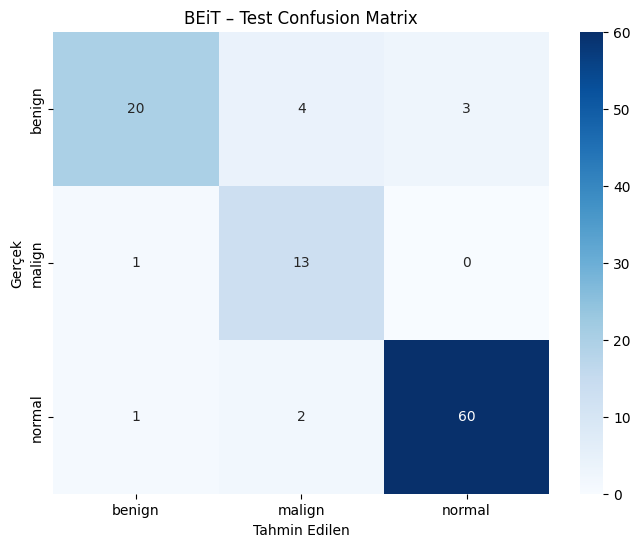

In [18]:
import torch
import torch.nn as nn
import timm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- 1. AYARLAR ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = '/content/drive/MyDrive/Ara Proje/saved_models/TF models/beit_bus_uclm.pth'
test_dir = '/content/uclm_data/test'
batch_size = 32
num_classes = 3

# --- 2. TRANSFORM (EĞİTİMLE AYNI OLMALI) ---
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# --- 3. TEST DATA ---
test_data = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

class_names = test_data.classes
print("📂 Test sınıfları:", class_names)

# --- 4. MODELİ YÜKLE ---
available_beits = timm.list_models('*beit_tiny_patch16_224*', pretrained=False)
if not available_beits:
    available_beits = timm.list_models('*beit_base_patch16_224*', pretrained=False)

model_name = available_beits[0]
model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)

checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

print("✅ Model Drive'dan yüklendi")

# --- 5. TEST TAHMİNLERİ ---
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

# --- 6. METRİKLER ---
acc = accuracy_score(y_true, y_pred)
print("-" * 50)
print(f"✅ Test Accuracy: %{acc*100:.2f}")
print("-" * 50)

print("📊 Precision / Recall / F1 Sonuçları:")
print(classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    digits=4
))


# --- 7. CONFUSION MATRIX (GÖRSEL) ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("BEiT – Test Confusion Matrix")
plt.show()


# cait

In [5]:
# 1. Kütüphaneler
!pip install timm
import torch
import torch.nn as nn
import timm
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive

# 2. Drive ve Kayıt Yolu (v5 - CaiT Modeli)
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/Ara Proje/saved_models/TF models/cait_bus_uclm.pth'


# 2. Klasör Yolları
train_dir = '/content/uclm_data/train'
valid_dir = '/content/uclm_data/val'
test_dir = '/content/uclm_data/test'


# 4. Veri Dönüşümleri
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 5. Dataset ve DataLoader
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=val_test_transform)
test_data = datasets.ImageFolder(test_dir, transform=val_test_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# 6. CaiT Model Kurulumu (Meşhur ve Güçlü)
# 'cait_s24_224' modeli, derinliği ve performansıyla bilinir.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('cait_s24_224', pretrained=True, num_classes=3)
model.to(device)



optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.05) # CaiT için biraz daha düşük LR iyidir
criterion = nn.CrossEntropyLoss()

# 7. Eğitim Döngüsü (Early Stopping ile)
epochs = 50
best_acc = 0.0
patience = 5
counter = 0

print(f"\n🚀 CaiT Transformer Eğitimi Başlıyor... (Cihaz: {device})")

for epoch in range(epochs):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100. * val_correct / val_total
    print(f'Epoch [{epoch+1}/{epochs}] - Loss: {train_loss/len(train_loader):.4f} - Train Acc: %{100.*train_correct/train_total:.2f} - Val Acc: %{val_acc:.2f}')

    if val_acc > best_acc:
        best_acc = val_acc
        counter = 0
        torch.save({'model_state_dict': model.state_dict(), 'best_acc': best_acc}, save_path)
        print(f'⭐ En İyi CaiT Modeli Kaydedildi!')
    else:
        counter += 1
        if counter >= patience:
            print(f'🛑 Early Stopping: %{best_acc:.2f} val başarısında durduruldu.')
            break

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


model.safetensors:   0%|          | 0.00/188M [00:00<?, ?B/s]


🚀 CaiT Transformer Eğitimi Başlıyor... (Cihaz: cuda)
Epoch [1/50] - Loss: 0.6010 - Train Acc: %72.98 - Val Acc: %91.18
⭐ En İyi CaiT Modeli Kaydedildi!
Epoch [2/50] - Loss: 0.1317 - Train Acc: %95.33 - Val Acc: %91.18
Epoch [3/50] - Loss: 0.0537 - Train Acc: %98.21 - Val Acc: %93.14
⭐ En İyi CaiT Modeli Kaydedildi!
Epoch [4/50] - Loss: 0.0348 - Train Acc: %98.87 - Val Acc: %94.12
⭐ En İyi CaiT Modeli Kaydedildi!
Epoch [5/50] - Loss: 0.0065 - Train Acc: %99.91 - Val Acc: %93.14
Epoch [6/50] - Loss: 0.0144 - Train Acc: %99.53 - Val Acc: %95.10
⭐ En İyi CaiT Modeli Kaydedildi!
Epoch [7/50] - Loss: 0.0099 - Train Acc: %99.76 - Val Acc: %92.16
Epoch [8/50] - Loss: 0.0228 - Train Acc: %99.29 - Val Acc: %92.16
Epoch [9/50] - Loss: 0.0213 - Train Acc: %99.10 - Val Acc: %91.18
Epoch [10/50] - Loss: 0.0389 - Train Acc: %98.92 - Val Acc: %93.14
Epoch [11/50] - Loss: 0.0031 - Train Acc: %99.95 - Val Acc: %92.16
🛑 Early Stopping: %95.10 val başarısında durduruldu.


In [17]:
import torch
import timm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- 1. Cihaz ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. Modeli tekrar kur (AYNI MİMARİ) ---
model = timm.create_model('cait_s24_224', pretrained=False, num_classes=3)
model.to(device)

# --- 3. Drive'dan en iyi modeli yükle ---
checkpoint = torch.load(
    '/content/drive/MyDrive/Ara Proje/saved_models/TF models/cait_bus_uclm.pth',
    map_location=device
)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Model yüklendi | Best Val Acc: %{checkpoint['best_acc']:.2f}")

# --- 4. Test Tahminleri ---
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- 5. Sonuçlar ---
class_names = test_data.classes  # ImageFolder'dan otomatik gelir

print("\n📊 TEST SONUÇLARI")
print("--------------------------------------------------")

# Accuracy
test_acc = accuracy_score(all_labels, all_preds)
print(f"🎯 Test Accuracy: %{test_acc*100:.2f}")

# Classification Report
print("\n📄 Classification Report:")
print(classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    digits=4
))


# Confusion Matrix
print("🧩 Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


✅ Model yüklendi | Best Val Acc: %95.10

📊 TEST SONUÇLARI
--------------------------------------------------
🎯 Test Accuracy: %87.50

📄 Classification Report:
              precision    recall  f1-score   support

      benign     0.8636    0.7037    0.7755        27
      malign     0.7500    0.8571    0.8000        14
      normal     0.9091    0.9524    0.9302        63

    accuracy                         0.8750       104
   macro avg     0.8409    0.8377    0.8352       104
weighted avg     0.8759    0.8750    0.8725       104

🧩 Confusion Matrix:
[[19  3  5]
 [ 1 12  1]
 [ 2  1 60]]


In [9]:
# 1. Kütüphaneler
!pip install timm
import torch
import torch.nn as nn
import timm
import os
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive

# 2. Drive ve Kayıt Yolu (Swin için v4 olarak kaydediyoruz)
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/Ara Proje/saved_models/TF models/swin_bus_UCLM.pth'
# 2. Klasör Yolları
train_dir = '/content/uclm_data/train'
valid_dir = '/content/uclm_data/val'
test_dir = '/content/uclm_data/test'

# 4. Veri Dönüşümleri (Transformations)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 5. Dataset ve DataLoader
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=val_test_transform)
test_data = datasets.ImageFolder(test_dir, transform=val_test_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"✅ Veri Setleri Hazır (Swin için)")
print(f"Eğitim: {len(train_data)} | Doğrulama: {len(valid_data)} | Test: {len(test_data)}")

# 6. Swin Transformer Model Kurulumu
# 'swin_tiny_patch4_window7_224' modelini kullanıyoruz
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=3)
model.to(device)



optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
criterion = nn.CrossEntropyLoss()

# 7. Eğitim Döngüsü ve Early Stopping
epochs = 50
best_acc = 0.0
patience = 5
counter = 0

print(f"\n🚀 Swin Transformer Eğitimi Başlıyor... (Cihaz: {device})")

for epoch in range(epochs):
    # --- TRAIN ---
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    # --- VALIDATION ---
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100. * val_correct / val_total

    print(f'Epoch [{epoch+1}/{epochs}] - Loss: {train_loss/len(train_loader):.4f} - Train Acc: %{100.*train_correct/train_total:.2f} - Val Acc: %{val_acc:.2f}')

    # Save Best Model
    if val_acc > best_acc:
        best_acc = val_acc
        counter = 0
        torch.save({'model_state_dict': model.state_dict(), 'best_acc': best_acc}, save_path)
        print(f'⭐ Yeni En İyi Swin Modeli Kaydedildi (Val Acc: %{best_acc:.2f})')
    else:
        counter += 1
        if counter >= patience:
            print(f'🛑 Early Stopping tetiklendi. En iyi Swin Val Acc: %{best_acc:.2f}')
            break

print("\n✅ Swin eğitimi bitti. Sonuçlar gelince test aşamasına geçelim.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Veri Setleri Hazır (Swin için)
Eğitim: 2121 | Doğrulama: 102 | Test: 104


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]


🚀 Swin Transformer Eğitimi Başlıyor... (Cihaz: cuda)
Epoch [1/50] - Loss: 0.8616 - Train Acc: %58.18 - Val Acc: %86.27
⭐ Yeni En İyi Swin Modeli Kaydedildi (Val Acc: %86.27)
Epoch [2/50] - Loss: 0.4546 - Train Acc: %81.75 - Val Acc: %92.16
⭐ Yeni En İyi Swin Modeli Kaydedildi (Val Acc: %92.16)
Epoch [3/50] - Loss: 0.2045 - Train Acc: %92.79 - Val Acc: %89.22
Epoch [4/50] - Loss: 0.1322 - Train Acc: %95.66 - Val Acc: %89.22
Epoch [5/50] - Loss: 0.1055 - Train Acc: %96.46 - Val Acc: %92.16
Epoch [6/50] - Loss: 0.0596 - Train Acc: %98.07 - Val Acc: %95.10
⭐ Yeni En İyi Swin Modeli Kaydedildi (Val Acc: %95.10)
Epoch [7/50] - Loss: 0.0529 - Train Acc: %98.49 - Val Acc: %92.16
Epoch [8/50] - Loss: 0.0531 - Train Acc: %98.30 - Val Acc: %91.18
Epoch [9/50] - Loss: 0.0559 - Train Acc: %97.88 - Val Acc: %94.12
Epoch [10/50] - Loss: 0.0327 - Train Acc: %98.87 - Val Acc: %96.08
⭐ Yeni En İyi Swin Modeli Kaydedildi (Val Acc: %96.08)
Epoch [11/50] - Loss: 0.0323 - Train Acc: %99.34 - Val Acc: %96.0

In [16]:
import torch
import timm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- 1. Cihaz ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. Modeli AYNI mimariyle tekrar kur ---
model = timm.create_model(
    'swin_tiny_patch4_window7_224',
    pretrained=False,
    num_classes=3
)
model.to(device)

# --- 3. Drive'dan en iyi Swin modelini yükle ---
checkpoint = torch.load(
    '/content/drive/MyDrive/Ara Proje/saved_models/TF models/swin_bus_UCLM.pth',
    map_location=device
)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Swin modeli yüklendi | Best Val Acc: %{checkpoint['best_acc']:.2f}")

# --- 4. Test Tahminleri ---
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:   # SADECE test_loader
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- 5. Test Sonuçları ---
class_names = test_data.classes  # ImageFolder sınıf isimleri

print("\n📊 SWIN TRANSFORMER – TEST SONUÇLARI")
print("--------------------------------------------------")

# Accuracy
test_acc = accuracy_score(all_labels, all_preds)
print(f"🎯 Test Accuracy: %{test_acc*100:.2f}")

# Classification Report
print("\n📄 Classification Report:")
print(classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    digits=4
))


# Confusion Matrix (YAZDIRILAN – görsel yok)
print("🧩 Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


✅ Swin modeli yüklendi | Best Val Acc: %96.08

📊 SWIN TRANSFORMER – TEST SONUÇLARI
--------------------------------------------------
🎯 Test Accuracy: %91.35

📄 Classification Report:
              precision    recall  f1-score   support

      benign     0.8462    0.8148    0.8302        27
      malign     0.9231    0.8571    0.8889        14
      normal     0.9385    0.9683    0.9531        63

    accuracy                         0.9135       104
   macro avg     0.9026    0.8801    0.8907       104
weighted avg     0.9124    0.9135    0.9126       104

🧩 Confusion Matrix:
[[22  1  4]
 [ 2 12  0]
 [ 2  0 61]]


In [12]:
# 1. Kütüphaneler
!pip install timm
import torch
import torch.nn as nn
import timm
import os
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive

# 2. Drive ve Kayıt Yolu
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/Ara Proje/saved_models/TF models/deit_bus_UCLM.pth'

# 3. Klasör Yollarını Tanımla
train_dir = '/content/uclm_data/train'
valid_dir = '/content/uclm_data/val'
test_dir = '/content/uclm_data/test'

# 4. Veri Dönüşümleri (Transformations)
# Train için augmentation (artırma), Valid/Test için sadece normalize
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 5. Dataset ve DataLoader Oluşturma
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=val_test_transform)
test_data = datasets.ImageFolder(test_dir, transform=val_test_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"✅ Veri Setleri Hazır:")
print(f"Eğitim (Train): {len(train_data)} | Doğrulama (Valid): {len(valid_data)} | Test: {len(test_data)}")

# 6. DeiT Model Kurulumu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('deit_tiny_patch16_224', pretrained=True, num_classes=3)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
criterion = nn.CrossEntropyLoss()

# 7. Eğitim Döngüsü ve Early Stopping
epochs = 50
best_acc = 0.0
patience = 5
counter = 0

print(f"\n🚀 Disiplinli Eğitim Başlıyor... (Cihaz: {device})")

for epoch in range(epochs):
    # --- TRAIN ---
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    # --- VALIDATION ---
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100. * val_correct / val_total

    print(f'Epoch [{epoch+1}/{epochs}] - Loss: {train_loss/len(train_loader):.4f} - Train Acc: %{100.*train_correct/train_total:.2f} - Val Acc: %{val_acc:.2f}')

    # Save Best Model based on Validation Accuracy
    if val_acc > best_acc:
        best_acc = val_acc
        counter = 0
        torch.save({'model_state_dict': model.state_dict(), 'best_acc': best_acc}, save_path)
        print(f'⭐ En İyi Model Kaydedildi (Val Acc: %{best_acc:.2f})')
    else:
        counter += 1
        if counter >= patience:
            print(f'🛑 Early Stopping tetiklendi. En iyi Val Acc: %{best_acc:.2f}')
            break

print("\n✅ Eğitim bitti. Şimdi Test klasörüyle final performansını ölçebiliriz.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Veri Setleri Hazır:
Eğitim (Train): 2121 | Doğrulama (Valid): 102 | Test: 104


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]


🚀 Disiplinli Eğitim Başlıyor... (Cihaz: cuda)
Epoch [1/50] - Loss: 0.6982 - Train Acc: %69.54 - Val Acc: %85.29
⭐ En İyi Model Kaydedildi (Val Acc: %85.29)
Epoch [2/50] - Loss: 0.3382 - Train Acc: %88.07 - Val Acc: %89.22
⭐ En İyi Model Kaydedildi (Val Acc: %89.22)
Epoch [3/50] - Loss: 0.2255 - Train Acc: %91.42 - Val Acc: %92.16
⭐ En İyi Model Kaydedildi (Val Acc: %92.16)
Epoch [4/50] - Loss: 0.1128 - Train Acc: %96.13 - Val Acc: %91.18
Epoch [5/50] - Loss: 0.0788 - Train Acc: %97.50 - Val Acc: %93.14
⭐ En İyi Model Kaydedildi (Val Acc: %93.14)
Epoch [6/50] - Loss: 0.1050 - Train Acc: %96.37 - Val Acc: %94.12
⭐ En İyi Model Kaydedildi (Val Acc: %94.12)
Epoch [7/50] - Loss: 0.0699 - Train Acc: %97.83 - Val Acc: %92.16
Epoch [8/50] - Loss: 0.0561 - Train Acc: %98.02 - Val Acc: %93.14
Epoch [9/50] - Loss: 0.0545 - Train Acc: %98.35 - Val Acc: %93.14
Epoch [10/50] - Loss: 0.0413 - Train Acc: %98.68 - Val Acc: %92.16
Epoch [11/50] - Loss: 0.0182 - Train Acc: %99.53 - Val Acc: %92.16
🛑 Ear

✅ Model yüklendi | Best Val Acc: %94.12

📊 TEST SETİ SINIF DAĞILIMI:
benign: 27
malign: 14
normal: 63

🎯 TEST ACCURACY: %82.69


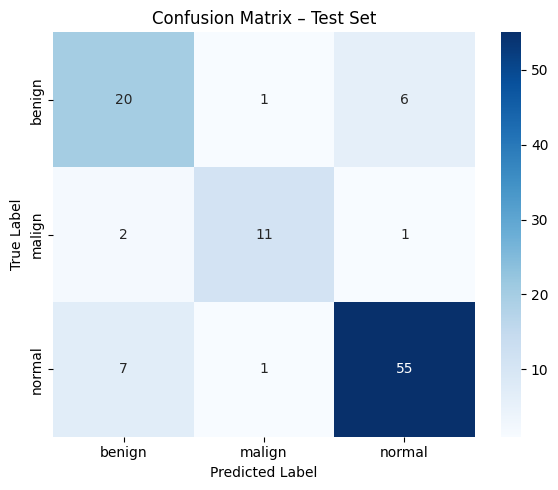


📄 CLASSIFICATION REPORT (TEST SET):
              precision    recall  f1-score   support

      benign     0.6897    0.7407    0.7143        27
      malign     0.8462    0.7857    0.8148        14
      normal     0.8871    0.8730    0.8800        63

    accuracy                         0.8269       104
   macro avg     0.8076    0.7998    0.8030       104
weighted avg     0.8303    0.8269    0.8282       104



In [15]:
# ================================
# TEST EVALUATION (TEK PARÇA)
# ================================

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------
# MODELİ YÜKLE
# ----------------
checkpoint = torch.load(save_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

print(f"✅ Model yüklendi | Best Val Acc: %{checkpoint['best_acc']:.2f}")

# ----------------
# TEST SETİ SINIF DAĞILIMI
# ----------------
test_labels = [label for _, label in test_data.samples]
class_counts = Counter(test_labels)

print("\n📊 TEST SETİ SINIF DAĞILIMI:")
for idx, count in class_counts.items():
    print(f"{test_data.classes[idx]}: {count}")

# ----------------
# TEST TAHMİNLERİ
# ----------------
all_preds = []
all_labels = []

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)

        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100. * correct / total
print(f"\n🎯 TEST ACCURACY: %{test_acc:.2f}")

# ----------------
# CONFUSION MATRIX
# ----------------
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=test_data.classes,
    yticklabels=test_data.classes
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Test Set")
plt.tight_layout()
plt.show()

# ----------------
# CLASSIFICATION REPORT
# ----------------
print("\n📄 CLASSIFICATION REPORT (TEST SET):")
print(classification_report(
    all_labels,
    all_preds,
    target_names=test_data.classes,
    digits=4

))


In [19]:
# ===============================
# 1. KÜTÜPHANELER
# ===============================
!pip install timm

import torch
import torch.nn as nn
import timm
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive

# ===============================
# 2. DRIVE BAĞLANTISI & KAYIT YOLU
# ===============================
drive.mount('/content/drive')

save_path = '/content/drive/MyDrive/Ara Proje/saved_models/TF models/vit_standard_uclm.pth'

# ===============================
# 3. DATASET YOLLARI
# ===============================
train_dir = '/content/uclm_data/train'
valid_dir = '/content/uclm_data/val'
test_dir  = '/content/uclm_data/test'

# ===============================
# 4. TRANSFORMLAR (ViT Standard)
# ===============================
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ===============================
# 5. DATASET & DATALOADER
# ===============================
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=val_test_transform)
test_data  = datasets.ImageFolder(test_dir,  transform=val_test_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False)

print(f"✅ Veri setleri hazır")
print(f"Train: {len(train_data)} | Val: {len(valid_data)} | Test: {len(test_data)}")

# ===============================
# 6. VISION TRANSFORMER (STANDARD)
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔹 Standard ViT (Baseline)
model = timm.create_model(
    'vit_base_patch16_224',
    pretrained=True,
    num_classes=3
)
model.to(device)

# ===============================
# 7. OPTIMIZER & LOSS
# ===============================
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-5,              # ViT için ideal
    weight_decay=0.05
)

criterion = nn.CrossEntropyLoss()

# ===============================
# 8. TRAINING + EARLY STOPPING
# ===============================
epochs = 50
best_acc = 0.0
patience = 5
counter = 0

print(f"\n🚀 ViT (Standard) Eğitimi Başlıyor... (Cihaz: {device})")

for epoch in range(epochs):
    # ---- TRAIN ----
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    # ---- VALIDATION ----
    model.eval()
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100. * val_correct / val_total

    print(
        f"Epoch [{epoch+1}/{epochs}] | "
        f"Loss: {train_loss/len(train_loader):.4f} | "
        f"Train Acc: %{100.*train_correct/train_total:.2f} | "
        f"Val Acc: %{val_acc:.2f}"
    )

    # ---- SAVE BEST MODEL ----
    if val_acc > best_acc:
        best_acc = val_acc
        counter = 0
        torch.save(
            {'model_state_dict': model.state_dict(), 'best_acc': best_acc},
            save_path
        )
        print(f"⭐ En iyi ViT modeli kaydedildi (Val Acc: %{best_acc:.2f})")
    else:
        counter += 1
        if counter >= patience:
            print(f"🛑 Early Stopping – En iyi Val Acc: %{best_acc:.2f}")
            break

print("\n✅ ViT (Standard) eğitimi tamamlandı.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Veri setleri hazır
Train: 2121 | Val: 102 | Test: 104


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


🚀 ViT (Standard) Eğitimi Başlıyor... (Cihaz: cuda)
Epoch [1/50] | Loss: 0.8635 | Train Acc: %61.29 | Val Acc: %85.29
⭐ En iyi ViT modeli kaydedildi (Val Acc: %85.29)
Epoch [2/50] | Loss: 0.2870 | Train Acc: %89.16 | Val Acc: %95.10
⭐ En iyi ViT modeli kaydedildi (Val Acc: %95.10)
Epoch [3/50] | Loss: 0.1131 | Train Acc: %96.23 | Val Acc: %89.22
Epoch [4/50] | Loss: 0.0558 | Train Acc: %98.11 | Val Acc: %95.10
Epoch [5/50] | Loss: 0.0543 | Train Acc: %97.88 | Val Acc: %91.18
Epoch [6/50] | Loss: 0.0516 | Train Acc: %98.35 | Val Acc: %94.12
Epoch [7/50] | Loss: 0.0391 | Train Acc: %98.54 | Val Acc: %91.18
🛑 Early Stopping – En iyi Val Acc: %95.10

✅ ViT (Standard) eğitimi tamamlandı.


In [20]:
# ===============================
# ViT (STANDARD) – TEST EVALUATION
# ===============================

import torch
import timm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# -------------------------------
# 1. CİHAZ
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# 2. MODELİ AYNI MİMARİYLE KUR
# -------------------------------
model = timm.create_model(
    'vit_base_patch16_224',
    pretrained=False,
    num_classes=3
)
model.to(device)

# -------------------------------
# 3. EN İYİ MODELİ DRIVE'DAN YÜKLE
# -------------------------------
checkpoint = torch.load(
    '/content/drive/MyDrive/Ara Proje/saved_models/TF models/vit_standard_uclm.pth',
    map_location=device
)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ ViT modeli yüklendi | Best Val Acc: %{checkpoint['best_acc']:.4f}")

# -------------------------------
# 4. TEST TAHMİNLERİ
# -------------------------------
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# -------------------------------
# 5. TEST SONUÇLARI
# -------------------------------
class_names = test_data.classes

print("\n📊 ViT (Standard) – TEST SONUÇLARI")
print("--------------------------------------------------")

# Accuracy (küsürat artırıldı)
test_acc = accuracy_score(all_labels, all_preds)
print(f"🎯 Test Accuracy: %{test_acc*100:.4f}")

# Classification Report (4 basamak)
print("\n📄 Classification Report:")
print(classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    digits=4
))

# Confusion Matrix (yazılı)
print("🧩 Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


✅ ViT modeli yüklendi | Best Val Acc: %95.0980

📊 ViT (Standard) – TEST SONUÇLARI
--------------------------------------------------
🎯 Test Accuracy: %91.3462

📄 Classification Report:
              precision    recall  f1-score   support

      benign     0.8800    0.8148    0.8462        27
      malign     0.8125    0.9286    0.8667        14
      normal     0.9524    0.9524    0.9524        63

    accuracy                         0.9135       104
   macro avg     0.8816    0.8986    0.8884       104
weighted avg     0.9148    0.9135    0.9133       104

🧩 Confusion Matrix:
[[22  2  3]
 [ 1 13  0]
 [ 2  1 60]]


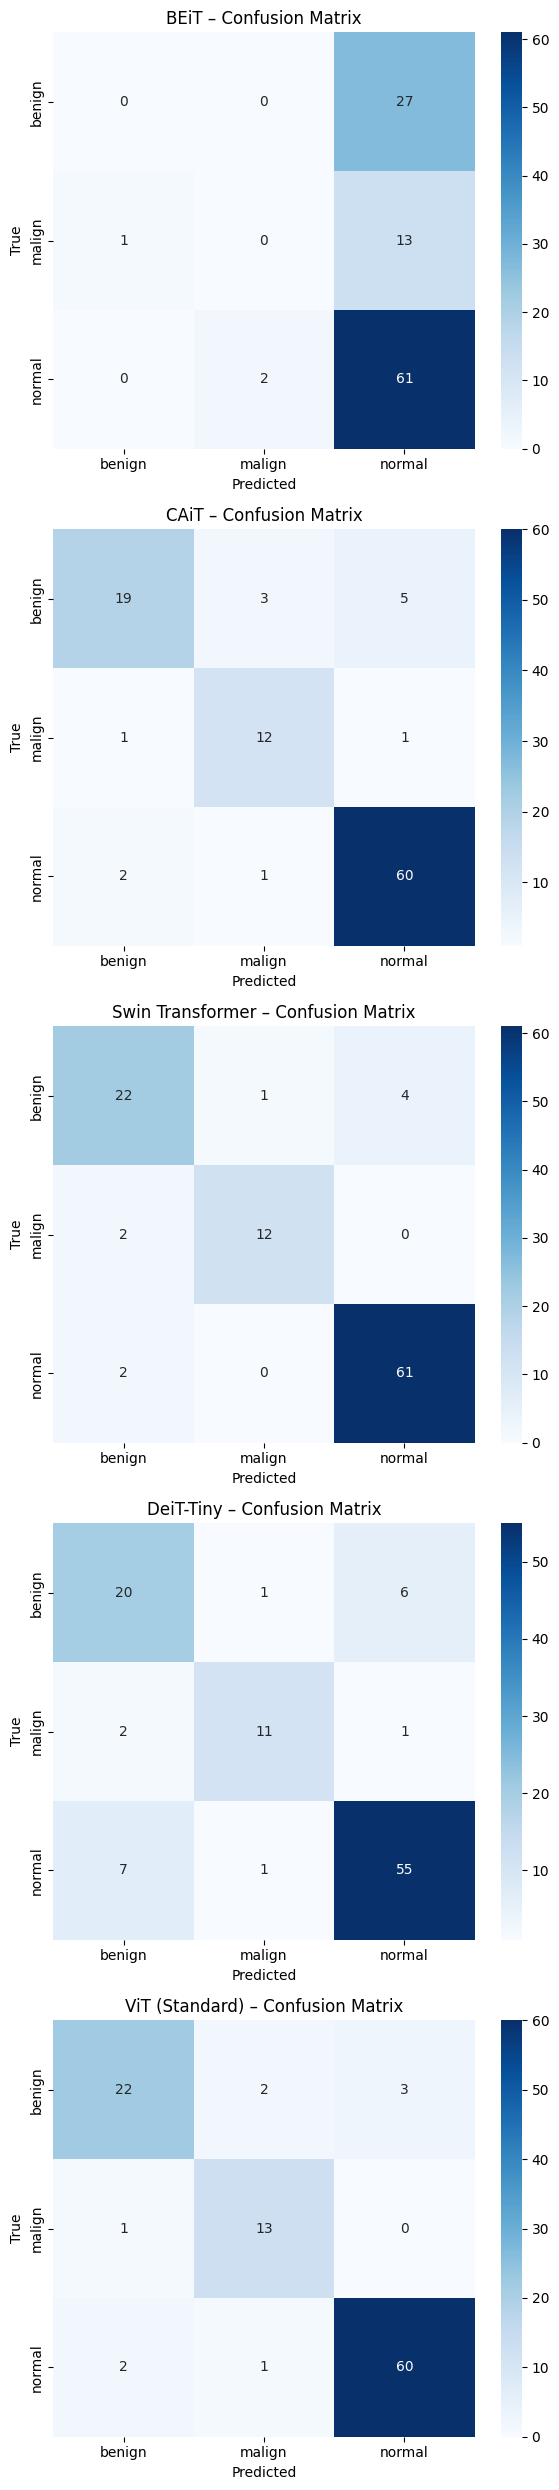

In [21]:
# =========================================
# 5 TRANSFORMER MODEL – CONFUSION MATRICES
# BEiT | CAiT | Swin | DeiT | ViT
# =========================================

import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------------------
# MODEL TANIMLARI (isim, timm_id, path)
# -----------------------------------------
models_info = [
    ("BEiT", "beit_base_patch16_224",
     "/content/drive/MyDrive/Ara Proje/saved_models/TF models/beit_bus_uclm.pth"),

    ("CAiT", "cait_s24_224",
     "/content/drive/MyDrive/Ara Proje/saved_models/TF models/cait_bus_uclm.pth"),

    ("Swin Transformer", "swin_tiny_patch4_window7_224",
     "/content/drive/MyDrive/Ara Proje/saved_models/TF models/swin_bus_UCLM.pth"),

    ("DeiT-Tiny", "deit_tiny_patch16_224",
     "/content/drive/MyDrive/Ara Proje/saved_models/TF models/deit_bus_UCLM.pth"),

    ("ViT (Standard)", "vit_base_patch16_224",
     "/content/drive/MyDrive/Ara Proje/saved_models/TF models/vit_standard_uclm.pth"),
]

class_names = test_data.classes

# -----------------------------------------
# FIGURE
# -----------------------------------------
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(6, 25))

# -----------------------------------------
# HER MODEL İÇİN TEST + CM
# -----------------------------------------
for idx, (model_title, model_name, weight_path) in enumerate(models_info):

    # Modeli kur
    model = timm.create_model(
        model_name,
        pretrained=False,
        num_classes=len(class_names)
    ).to(device)

    # Ağırlıkları yükle
    checkpoint = torch.load(weight_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        ax=axes[idx]
    )

    axes[idx].set_title(f"{model_title} – Confusion Matrix")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("True")

plt.tight_layout()
plt.show()
